# Fitting Equal-Sized K-Means

NOTE: Code will not run without the data directory in the head of the repository. The files are too large to store on Github and can be downloaded from [https://openaddresses.io](https://openaddresses.io) and saved in `gerrymandering/data`.

In [57]:
# Import packages

## Core packages
import pandas as pd
import numpy as np

## Directory manipulation
import glob
import os

## Fitting and mathematics
import k_means_eq
from geovoronoi import voronoi_regions_from_coords

## Plotting
import matplotlib.pyplot as plt
from pylab import *
import plotly.express as px
import geopandas as gpd
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area

## Quality of life
from tqdm.notebook import tqdm

In [30]:
# Read in summary data
df_state_info = pd.read_csv("../../dash/state_summary.csv", dtype={"fips": str})

In [34]:
# Consolidate address files (if separated)
## Set static variables
root_directory = os.path.dirname(os.path.dirname(os.getcwd()))
extension = 'csv'
## Loop through every avaliable file per state
for i in tqdm(df_state_info["state_abbrev"].str.lower()):
    working_directory = root_directory + "/data/" + i + "/"
    ## In case a file was not downloaded, error is handled
    try:
        os.chdir(working_directory)
    except FileNotFoundError:
        pass
    else:
        files = [i for i in glob.glob('*.{}'.format(extension))]
        if any("statewide" in filename for filename in files):
            filtered_files = [filename for filename in files if "statewide" in filename]
        else:
            filtered_files = files
        combined_files = pd.concat([
            pd.read_csv(f, low_memory=False) for f in filtered_files
        ])
        combined_files.to_csv(root_directory + "/data/" + i + ".csv", index=False)

#### NOTE: Some fit times will take much longer than others. We will go through one example of how to fit data using our algorithm.

In [31]:
# Define the state we are fitting as well as the number of congressional seats
state = "nc"
seats = df_state_info[df_state_info["state_abbrev"].str.lower() == state]["seats"].iloc[0]
fips = df_state_info[df_state_info["state_abbrev"].str.lower() == state]["fips"].iloc[0]

In [46]:
# Read in addresses from the state
df_state = pd.read_csv(root_directory + "/data/" + state + ".csv", low_memory=False)
# Remove all unnecessary data, all we need are the latitude/longitude coordinates
df_state = df_state[[
    "LON",
    "LAT",
]]
array_state = np.array(df_state)

In [47]:
# Fit the equal KMeans model, number of clusters are the number of congressional seats
clf = k_means_eq.EqualGroupsKMeans(n_clusters=seats)
clf.fit(array_state)

EqualGroupsKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=13,
         n_init=10, n_jobs=1, precompute_distances='auto',
         random_state=None, tol=0.0001, verbose=0)

In [48]:
# Assign cluster and save centroids in CSV format
df_state["CLUSTER"] = clf.labels_
centroids = clf.cluster_centers_
df_districts = pd.DataFrame(centroids, columns=["LON", "LAT"])
df_districts["CLUSTER"] = df_state["CLUSTER"].sort_values().unique()
df_districts.to_csv("../../results/" + state + "_centroids.csv", index=False)

In [74]:
45 // 20

2

In [4]:
# Read in centroids (if only plotting, otherwise run whole notebook top to bottom)
df_districts = pd.read_csv("../../results/" + state + "_centroids.csv")

In [56]:
# Read in shapefiles
## Congressional districts shapefile
df_shp_base = gpd.read_file("../../shapefile/congressional_districts/tl_2019_us_cd116.shp")
base_districts = df_shp_base[df_shp_base["STATEFP"] == fips]["geometry"]
## State boundaries shapefile
df_shp = gpd.read_file("../../shapefile/states/tl_2019_us_state.shp")
base_state = df_shp[df_shp["STUSPS"].str.lower() == state]
base_state_shape = base_state["geometry"].iloc[0]

In [79]:
# Get appropriate number of colors for plotting in `geopandas`
cmap = cm.get_cmap('tab20', seats)
colors = []
for i in range(seats):
    i -= (20 * (i // 20))
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))

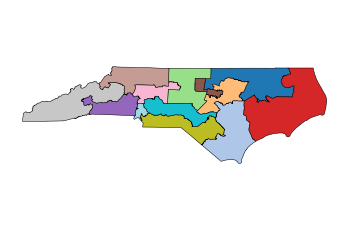

In [83]:
# Plot and save image of current congressional districts
fig, ax = plt.subplots(1)
# base_state.plot(color=colors, ax=ax, linewidth=1, edgecolor='0')
base_districts.plot(color=colors, ax=ax, linewidth=0.5, edgecolor='0')
df_shp[df_shp["STUSPS"].str.lower() == state]["geometry"]
ax.set_axis_off()
plt.axis("equal")
plt.savefig("../../img/"+ state + "_cd.png", bbox_inches='tight')
plt.show()

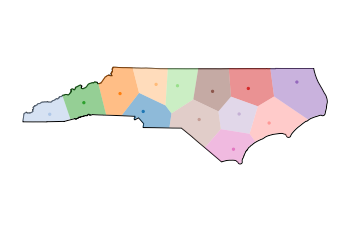

In [84]:
# Plot and save voronoi (centroid area of influence) plot of K-Means districts 
districts = np.array(df_districts[[
    "LON",
    "LAT",
]])

poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(districts, base_state_shape)

fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, base_state_shape, poly_shapes, districts, poly_to_pt_assignments)
ax.set_axis_off()
plt.axis('equal')
plt.savefig("../../img/"+ state + "_fit.png", bbox_inches='tight')
plt.show()